In [5]:
#Load data and plot
DATASET_DIR = "/home/erdem/dataset/patches_urine_32_scaled"
CATEGORIES_ALL = ["Artifact", "BC", "cCry", "Dirt", "hCast", "LD", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "Unclassified", "WBC"]
CATEGORIES_INLIER = ["BC", "cCry", "hCast", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "WBC"]
CATEGORIES_OUTLIER = ["Artifact", "Dirt", "LD"]

In [6]:
import os
import cv2
import logging
import numpy as np
import methods
import torch as th
from skimage.util import random_noise
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
import seaborn as sns
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm
import albumentations as A

from functools import partial
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf

from alibi_detect.od import LLR
from alibi_detect.models.tensorflow import PixelCNN
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.tensorflow.prediction import predict_batch
from alibi_detect.utils.visualize import plot_roc, plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [7]:
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0, rotate_limit=90, scale_limit=[0,0.3], always_apply=True, p=1)
])

inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
dim = (32, 32)
height, width = dim
transformed_cCry = methods.getTransformedImages("cCry", dim, transform, 200)
transformed_sCry = methods.getTransformedImages("sCry", dim, transform, 40)
transformed_uCry = methods.getTransformedImages("uCry", dim, transform, 40)
transformed_hCast = methods.getTransformedImages("hCast", dim, transform, 200)
transformed_nhCast = methods.getTransformedImages("nhCast", dim, transform, 200)
transformed_nsEC = methods.getTransformedImages("nsEC", dim, transform, 20)
transformed_sEC = methods.getTransformedImages("sEC", dim, transform, 20)
transformed_WBC = methods.getTransformedImages("WBC", dim, transform, 10)
transformed_RBC = methods.getTransformedImages("RBC", dim, transform, 10)
transformed_BC = methods.getTransformedImages("BC", dim, transform, 4)

transformed_all = np.concatenate((transformed_cCry, transformed_sCry, transformed_uCry, transformed_hCast, 
                                 transformed_nhCast, transformed_nsEC, transformed_sEC, transformed_WBC,
                                 transformed_RBC, transformed_BC))

inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [8]:
inlier_dataset = []
outlier_dataset = []

def createInlierData():
    for category in CATEGORIES_INLIER:
        path = os.path.join(DATASET_DIR,category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                inlier_dataset.append(img_array)
            except Exception as e:
                pass

def createOutlierData():
    for category in CATEGORIES_OUTLIER:
        path = os.path.join(DATASET_DIR,category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                outlier_dataset.append(img_array)
            except Exception as e:
                pass

In [9]:
createInlierData()
createOutlierData()

X_inlier = np.array(inlier_dataset).reshape(-1, 32, 32, 1)
# X_inlier = X_inlier.astype('float32') / 255
# np.random.shuffle(X_inlier)

X_outlier = np.array(outlier_dataset).reshape(-1, 32, 32, 1)
# X_outlier = X_outlier.astype('float32') / 255
# np.random.shuffle(X_outlier)

print(X_inlier.shape)
print(X_outlier.shape)

(21416, 32, 32, 1)
(113, 32, 32, 1)


In [11]:
input_shape = X_inlier.shape[1:]
model = PixelCNN(
    image_shape=input_shape,
    num_resnet=5,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=1,
    receptive_field_dims=(3, 3),
    dropout_p=.3,
    l2_weight=0.
)

In [18]:
filepath = os.path.join(os.getcwd(), 'pixelcnn2')
kwargs = {'dist_s': model, 'dist_b': model.copy(), 'input_shape': input_shape}
od = load_detector(filepath, **kwargs)

No threshold level set. Need to infer threshold using `infer_threshold`.


In [19]:
def plot_grid_img(X: np.ndarray, figsize: tuple = (10, 6)) -> None:
    n = X.shape[0]
    nrows = int(n**.5)
    ncols = int(np.ceil(n / nrows))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    n_subplot = 1
    for r in range(nrows):
        for c in range(ncols):
            plt.subplot(nrows, ncols, n_subplot)
            plt.axis('off')
            plt.imshow(X[n_subplot-1, :, :, 0])
            n_subplot += 1

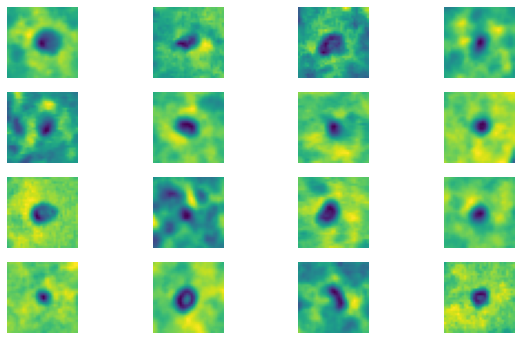

In [20]:
n_sample = 16
X_sample = od.dist_s.sample(n_sample).numpy()
plot_grid_img(X_sample)

In [ ]:
X_sample = od.dist_b.sample(n_sample).numpy()
plot_grid_img(X_sample)

In [22]:
print(od.dist_)

tfp.distributions.PixelCNN("PixelCNN", batch_shape=[], event_shape=[32, 32, 1], dtype=float32)


In [28]:
od.dist_s

<tfp.distributions.PixelCNN 'PixelCNN' batch_shape=[] event_shape=[32, 32, 1] dtype=float32>